In [32]:
import torch
from torch import nn
from torch import optim
import torchvision

from matplotlib import pyplot as plt

In [6]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [7]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [8]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [64]:
epochs = 50
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/50, loss = 0.013854
epoch : 2/50, loss = 0.013812
epoch : 3/50, loss = 0.013765
epoch : 4/50, loss = 0.013722
epoch : 5/50, loss = 0.013683
epoch : 6/50, loss = 0.013645
epoch : 7/50, loss = 0.013614
epoch : 8/50, loss = 0.013573
epoch : 9/50, loss = 0.013549
epoch : 10/50, loss = 0.013524
epoch : 11/50, loss = 0.013510
epoch : 12/50, loss = 0.013481
epoch : 13/50, loss = 0.013460
epoch : 14/50, loss = 0.013440
epoch : 15/50, loss = 0.013416
epoch : 16/50, loss = 0.013389
epoch : 17/50, loss = 0.013379
epoch : 18/50, loss = 0.013368
epoch : 19/50, loss = 0.013352
epoch : 20/50, loss = 0.013332
epoch : 21/50, loss = 0.013321
epoch : 22/50, loss = 0.013314
epoch : 23/50, loss = 0.013296
epoch : 24/50, loss = 0.013278
epoch : 25/50, loss = 0.013272
epoch : 26/50, loss = 0.013253
epoch : 27/50, loss = 0.013249
epoch : 28/50, loss = 0.013240
epoch : 29/50, loss = 0.013229
epoch : 30/50, loss = 0.013222
epoch : 31/50, loss = 0.013216
epoch : 32/50, loss = 0.013199
epoch : 33/50, lo

In [68]:
test_idx = 3

In [69]:
model.eval()

test_img = test_dataset[test_idx][0].view(-1, 784).to(device)
test_img = model(test_img).view(28, 28)

In [70]:
img = test_dataset[test_idx][0].to(device).float().squeeze()

Text(0.5, 1.0, 'Reconstructed')

<Figure size 432x288 with 0 Axes>

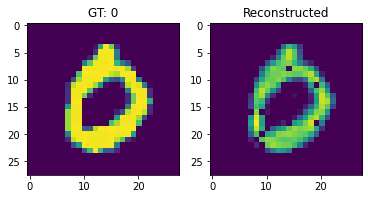

In [71]:
plt.figure()

f, ax = plt.subplots(1,2) 

ax[0].imshow(img.cpu().numpy())
ax[0].set_title("GT: " + str(test_dataset[test_idx][1]))
ax[1].imshow(test_img.detach().cpu().numpy())
ax[1].set_title("Reconstructed")